In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os
import random
import numpy as np
import pandas as pd
from pandas import DataFrame
import cPickle as pickle
import math
import copy

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [6]:
with open('../data/state_features.txt') as f:
    state_features = f.read().split()
print (state_features)
print len(state_features)

['Albumin', 'Arterial_BE', 'Arterial_lactate', 'Arterial_pH', 'BUN', 'CO2_mEqL', 'Calcium', 'Chloride', 'Creatinine', 'DiaBP', 'FiO2_1', 'GCS', 'Glucose', 'HCO3', 'HR', 'Hb', 'INR', 'Ionised_Ca', 'Magnesium', 'MeanBP', 'PT', 'PTT', 'PaO2_FiO2', 'Platelets_count', 'Potassium', 'RR', 'SGOT', 'SGPT', 'SIRS', 'SOFA', 'Shock_Index', 'Sodium', 'SpO2', 'SysBP', 'Temp_C', 'Total_bili', 'WBC_count', 'Weight_kg', 'age', 'elixhauser', 'gender', 'mechvent', 'output_4hourly', 'output_total', 'paCO2', 'paO2', 're_admission', 'bloc']
48


In [7]:
df = pd.read_csv('../data/rl_train_data_final_cont.csv')

In [8]:
df.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,vaso_input,iv_input,reward
0,0.000000,3,7245052800,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.797351,0.939195,0.589916,0.750908,0.554500,0.0,4.0,0.125000
1,0.222560,3,7245067200,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.831780,0.934543,0.674384,0.819589,0.580033,0.0,4.0,0.657321
2,0.356608,3,7245081600,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.833222,0.656575,0.765423,0.939329,0.555033,0.0,2.0,1.367788
3,0.452837,3,7245096000,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.834033,0.603831,0.783597,0.847073,0.545700,0.0,2.0,1.199099
4,0.527957,3,7245110400,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.834836,0.603831,0.794059,0.811583,0.539533,0.0,2.0,1.057596


In [9]:
val_df = pd.read_csv('../data/rl_val_data_final_cont.csv')

In [10]:
test_df = pd.read_csv('../data/rl_test_data_final_cont.csv')

In [11]:
# define an action mapping - how to get an id representing the action from the (iv,vaso) tuple
action_map = {}
count = 0
for iv in range(5):
    for vaso in range(5):
        action_map[(iv,vaso)] = count
        count += 1

In [12]:
inv_action_map = {}
for iv in range(5):
    for vaso in range(5):
        inv_action_map[5*iv+vaso] = [iv,vaso]    

In [13]:
# Extract features (state vector) and labels (action taken) out of the dataframe for train 
# and val sets
def preproc(df_in, iv_bins = 5):
    df = df_in.copy()
    actions_raw = df[['iv_input', 'vaso_input']].values
    keep_arr = np.loadtxt('../data/state_features.txt', dtype=str)
    df = df[keep_arr]
    actions_proc = (iv_bins*actions_raw[:, 0] + actions_raw[:, 1]).astype(int)
    hist = np.histogram(actions_proc, 25)
    actions_proc = pd.get_dummies(actions_proc).values
    #print(hist) just to check
    return df.values, actions_proc

In [14]:
def batch_sample(batch_size, features, labels):
    idx = np.random.choice(np.arange(len(features)), batch_size)
    return (np.vstack(features[idx]), np.vstack(labels[idx]))

In [15]:
train_feat, train_labels = preproc(df)
val_feat, val_labels = preproc(val_df)
test_feat, test_labels = preproc(test_df)

In [16]:
feature_length = len(train_feat[0])
batch_size = 64
num_actions = 25
num_steps = 35000
num_mix_comp = 5
hidden_size = 64
# we learn parameters for each of the mix components and the mixing probabilities
num_outputs = num_actions*num_mix_comp + num_mix_comp

In [28]:
class MixNN():
    def __init__(self):
        self.states = tf.placeholder(tf.float32, shape = [None, feature_length])
        
        self.actions = tf.placeholder(tf.float32, shape = [None, num_actions])
        
        self.old_posterior = tf.placeholder(tf.float32, shape = [None, num_mix_comp])
        
        self.phase = tf.placeholder(tf.bool)
        
        self.states3d = tf.tile(tf.expand_dims(self.states, axis=2), [1, 1, num_mix_comp])
        
        self.actions3d = tf.tile(tf.expand_dims(self.actions, axis=2), [1, 1, num_mix_comp])
        
        # this first part computes p(z|s), of dimension (bs, num_mix_comps)
        self.mixcomp_prob = self.mixcomp_net(self.states)

        # this next part computes p(a|s,z)
        self.mix_1 = tf.nn.relu(self.nn_mix_layer(self.states3d,feature_length,hidden_size, "mix_layer1"))
        self.mix_2 = tf.nn.relu(self.nn_mix_layer(self.mix_1,hidden_size,hidden_size, "mix_layer2"))
        self.mix_unnorm = self.nn_mix_layer(self.mix_1,hidden_size,num_actions, "mix_layer3")
        self.mix_cond_prob = tf.nn.softmax(self.mix_unnorm, dim=1) # this is of dimension (bs,num_act, mix_comp)

        
        # generate p(a, z | s) for analysis, where a is ALL actions
        #Firstly tile the mix probabilites. Currently it's of shape (bs, num_mix_comps). 
        #Convert to (bs, num_act, num_mix_comp)
        self.expanded_mix_prob = tf.tile(tf.expand_dims(self.mixcomp_prob, axis=1), [1, num_actions,1])
        
        self.joint_prob = self.expanded_mix_prob * self.mix_cond_prob
        
        # generate p(a_vec|s) by summing out 2 dimension. a_vec is a vector of ALL actions.
        # should be of dimension (bs,num_actions)
        self.lik_as_vec = tf.reduce_sum(self.joint_prob, axis=2)
        
        # select the actions actually taken
        self.vec = tf.tile(tf.expand_dims(self.actions, axis=2), [1,1,num_mix_comp])           
        
        # this is batchsize*num_actions*num_mix_comp. Sum out the num_actions dimension, which is zeroed out
        # due to multiplication by one hot self.vec, to get tensor of shape bs*num_mix_comp
        self.prob_actions_taken = tf.reduce_sum(self.vec*self.mix_cond_prob, axis=1) 
               
        # form the joint prob term of components and actions actually taken
        self.aux_joint = self.prob_actions_taken*self.mixcomp_prob
        
        # get the posterior for the current param setting: p(z|a,s), which is the E step of EM
        self.post_cur_params = tf.divide(self.aux_joint, tf.expand_dims(tf.reduce_sum(self.aux_joint, axis=1),1))
        
        # FORM AUX FUNC FOR M STEP
        # firstly get log aux joint
        self.log_aux_joint = tf.log(self.aux_joint)
        
        # multiply by OLD posterior, passed in as placeholder, and then reduce_sum
        self.aux = tf.reduce_sum(self.log_aux_joint * self.old_posterior)
        self.loss = -1*self.aux
        
        # also create one using current posterior as an example
        self.loss_cur_post = -1 * tf.reduce_sum(self.log_aux_joint * self.post_cur_params)

        self.update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(self.update_ops):
            self.train_step = tf.train.AdamOptimizer().minimize(self.loss)
    
    def mixcomp_net(self, inp):
        fc_1_mixcomp = tf.contrib.layers.fully_connected(inp, 128, activation_fn=tf.nn.relu)
        bn_1_mixcomp = tf.contrib.layers.batch_norm(fc_1_mixcomp, center=True, scale=True, is_training=self.phase)
        fc_2_mixcomp = tf.contrib.layers.fully_connected(bn_1_mixcomp , 128, activation_fn=tf.nn.relu)
        bn_2_mixcomp = tf.contrib.layers.batch_norm(fc_2_mixcomp, center=True, scale=True, is_training=self.phase)
        mixcomp_logit = tf.contrib.layers.fully_connected(bn_2_mixcomp , num_mix_comp, activation_fn=None)
        return tf.nn.softmax(mixcomp_logit)

    def nn_mix_layer(self, inp, d_in, d_out, scope):
        # inp is of size (batchsize,d_in,num_mix)
        # output produced is of size (batchsize, d_out, num_mix).
        # no activation added, so this works for last layer too
        W = tf.get_variable(str(scope) + "Wmix",shape = [d_in, d_out, num_mix_comp], 
                            initializer = tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(str(scope)+"bmix", shape = [d_out, num_mix_comp])
        # might need a tf.tile here for biases
        processed_inp = tf.einsum("ilk,ljk->ijk", inp, W) + b
        return processed_inp

In [29]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # Don't use all GPUs 
config.allow_soft_placement = True  # Enable manual control

In [34]:
def get_probs_for_analysis(dataset, sess, mdl):
    # get p(a_vec| s) for each entry in dataset -- this sums over the mixture components
    # get p(a_vec| s, z^(k)) for each entry in the dataset for each mix component -- 3D tensor
    if dataset == 'train':
        features, labels = train_feat,train_labels
    elif dataset == 'val':
        features, labels = val_feat,val_labels
    elif dataset == 'test':
        features, labels = test_feat,test_labels
    
    j = 0
    
    marginal_lik_vec = []
    conditional_lik_vec = []
    
    while (j < len(features)):
        feat = None
        lbls = None
        if len(features) - j < batch_size:
            feat = features[j:]
            lbls = labels[j:]
        else:
            feat = features[j:j+batch_size]
            lbls = labels[j:j+batch_size]
        feat = feat.reshape(len(feat), feature_length)
        acs = lbls.reshape(len(lbls), num_actions)
        if j % 10000 == 0: 
            print('Processing indx: ', j )
        
        batch_marg_lik_vec, batch_cond_lik_vec = sess.run([mdl.lik_as_vec, mdl.mix_cond_prob], 
                          feed_dict={mdl.states : feat, mdl.actions: acs, mdl.phase: 0})
        
        marginal_lik_vec.append(batch_marg_lik_vec)
        conditional_lik_vec.append(batch_cond_lik_vec)
        
        if len(features) - j < batch_size:
            j = len(features)
        else:
            j += batch_size
    
    marginal_lik_vec = np.vstack([arr for arr in marginal_lik_vec])
    conditional_lik_vec = np.vstack([arr for arr in conditional_lik_vec])
    return marginal_lik_vec, conditional_lik_vec

In [35]:
def get_posterior(dataset, sess, mdl):
    if dataset == 'train':
        features, labels = train_feat,train_labels
    elif dataset == 'val':
        features, labels = val_feat,val_labels
    elif dataset == 'test':
        features, labels = test_feat,test_labels
    
    j = 0
    
    posterior = []
    
    while (j < len(features)):
        feat = None
        lbls = None
        if len(features) - j < batch_size:
            feat = features[j:]
            lbls = labels[j:]
        else:
            feat = features[j:j+batch_size]
            lbls = labels[j:j+batch_size]
        feat = feat.reshape(len(feat), feature_length)
        acs = lbls.reshape(len(lbls), num_actions)
        if j % 10000 == 0: 
            print('Processing indx: ', j )
        
        post = sess.run(mdl.post_cur_params, 
                          feed_dict={mdl.states : feat, mdl.actions: acs, mdl.phase: 0})
        
        posterior.append(post)

        if len(features) - j < batch_size:
            j = len(features)
        else:
            j += batch_size
    
    posterior = np.vstack([arr for arr in posterior])

    return posterior


In [36]:
# Runs eval step.
# Do we want to use current posterior or old posterior? cur is probably better...
def run_eval(dataset,sess, mdl):
    if dataset == 'train':
        features, labels = train_feat,train_labels
    elif dataset == 'val':
        features, labels = val_feat,val_labels
    elif dataset == 'test':
        features, labels = test_feat,test_labels

    total_loss = 0
    j = 0
    while (j < len(features)):
        feat = None
        lbls = None
        if len(features) - j < batch_size:
            feat = features[j:-1]
            lbls = labels[j:-1]
        else:
            feat = features[j:j+batch_size]
            lbls = labels[j:j+batch_size]
        feat = feat.reshape(len(feat), feature_length)
        acs = lbls.reshape(len(lbls), num_actions)
        if j % 10000 == 0: 
            print('Processing val set indx: ', j )
        loss = sess.run(mdl.loss_cur_post, 
                          feed_dict={mdl.states : feat, mdl.actions: acs, mdl.phase: 0})
        total_loss += loss
        if len(features) - j < batch_size:
            j = len(features)
        else:
            j += batch_size
    return total_loss
    

In [39]:
# Idea when training:
# Init posteriors (E step)
# run M step for j epochs
# re-estimate post (E)
# run M step for j epochs
# repeat until convergence on val set (?) 

batch_size = 64
num_epochs = 5 # number of epochs to run M step for before re-estimating posteriors
num_E_steps = 6 # how many times to re-estimate E
load_model = False #Whether to load a saved model.
save_dir = "./MixNN_EM/"
save_path = "./MixNN_EM/ckpt"#The path to save our model to
tf.reset_default_graph()
mdl = MixNN()
do_analysis = False

saver = tf.train.Saver(tf.global_variables())

init = tf.global_variables_initializer()

trainables = tf.trainable_variables()

#Make a path for our model to be saved in.
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with tf.Session(config=config) as sess:
    if load_model == True:
        print('Trying to load model...')
        try:
            restorer = tf.train.import_meta_graph(save_path + '.meta')
            restorer.restore(sess, tf.train.latest_checkpoint(save_dir))
            print "Model restored"
        except IOError:
            print "No previous model found, running default init"
            sess.run(init)
    else:
        print("Running default init")
        sess.run(init)
    print("Init done")
    

    for e_step in range(num_E_steps):
        if do_analysis:
            marginal_lik, cond_lik = get_probs_for_analysis('val', sess, mdl)
            break
        # start by initialising the posterior 
        posterior = get_posterior('train', sess, mdl)

        for j in range(1,num_epochs+1):
            net_loss = 0.0
            inds = np.random.permutation(train_feat.shape[0])
            start_idx = 0
            end_idx = 0
            while start_idx < len(train_feat):
                end_idx = min(len(train_feat), start_idx+batch_size)
                batch_inds = inds[start_idx:end_idx]
                x_batch = train_feat[batch_inds]
                y_batch = train_labels[batch_inds]
                post_batch = posterior[batch_inds]

                # train using the batch
                _,loss = sess.run([mdl.train_step,mdl.loss], \
                feed_dict={mdl.states:x_batch,
                           mdl.actions:y_batch,
                           mdl.old_posterior:post_batch,
                           mdl.phase:True})

                # update net loss
                net_loss += loss

                # increment start index to inds
                start_idx += batch_size

            saver.save(sess,save_path)
            print("Saved Model, epoch " + str(j) + " E step is " + str(e_step))

            av_loss = net_loss/(len(train_feat)/float(batch_size))
            print("Average training loss per batch is " + str(av_loss) + " E step is " + str(e_step))
            net_loss = 0.0

            eval_loss = run_eval("val", sess, mdl)/(len(val_feat)/float(batch_size))

            print ("Avg val loss at epoch end is " + str(eval_loss) + " E step is " + str(e_step))
    
    marginal_lik, cond_lik = get_probs_for_analysis('val', sess, mdl)

   

Running default init
Init done
('Processing indx: ', 0)
('Processing indx: ', 40000)
('Processing indx: ', 80000)
('Processing indx: ', 120000)
('Processing indx: ', 160000)
Saved Model, epoch 1 E step is 0
Average training loss per batch is 230.100825874 E step is 0
('Processing val set indx: ', 0)
Avg val loss at epoch end is 221.683648761 E step is 0
Saved Model, epoch 2 E step is 0
Average training loss per batch is 218.473985817 E step is 0
('Processing val set indx: ', 0)
Avg val loss at epoch end is 216.892398415 E step is 0
Saved Model, epoch 3 E step is 0
Average training loss per batch is 215.366445803 E step is 0
('Processing val set indx: ', 0)
Avg val loss at epoch end is 215.935971277 E step is 0
Saved Model, epoch 4 E step is 0
Average training loss per batch is 213.730769258 E step is 0
('Processing val set indx: ', 0)
Avg val loss at epoch end is 213.663858675 E step is 0
Saved Model, epoch 5 E step is 0
Average training loss per batch is 212.722217228 E step is 0
('Pr

In [59]:
np.save('./MixNN_EM/marginal_lik_val.npy', marginal_lik)
np.save('./MixNN_EM/cond_lik_val.npy', cond_lik)

In [ ]:
# FIRSTLY, ARGMAX PLOTS

In [40]:
# get the argmaxes for the first analysis
actions_chosen = np.argmax(marginal_lik, axis=1)
val_labels_asvec = np.argmax(val_labels, axis=1)
mix_actions_chosen = np.argmax(cond_lik, axis=1)

In [55]:
print sum(actions_chosen == val_labels_asvec)/float(len(val_labels_asvec))

0.357136987427


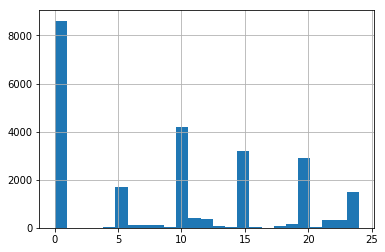

In [41]:
pd.Series(actions_chosen).hist(bins=25)

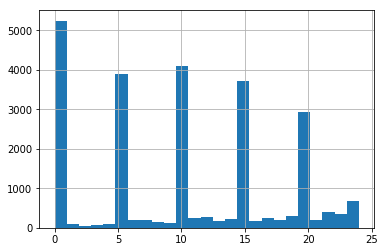

In [42]:
pd.Series(val_labels_asvec).hist(bins=25)

7482


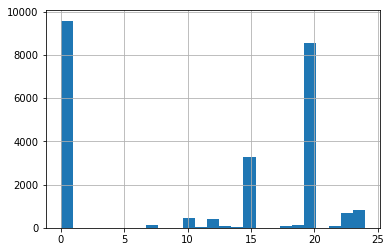

8066


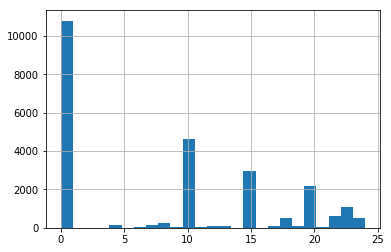

7763


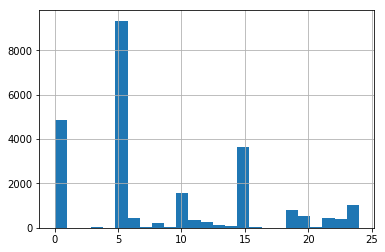

8329


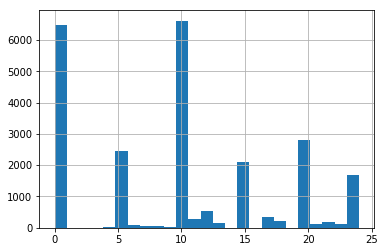

8033


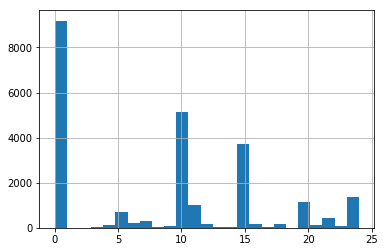

In [43]:
for i in range(num_mix_comp):
    pd.Series(mix_actions_chosen[:,i]).hist(bins=25)
    print sum(mix_actions_chosen[:,i] == val_labels_asvec)
    plt.show()

In [45]:
# get the means for the second analysis
ml_mean = np.mean(marginal_lik, axis=0)
cl_mean = np.mean(cond_lik, axis=0)

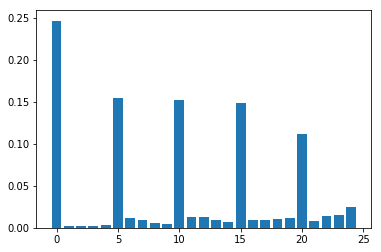

In [46]:
_ = plt.bar(range(25), ml_mean)

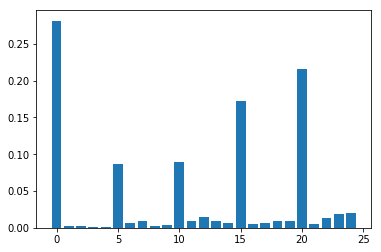

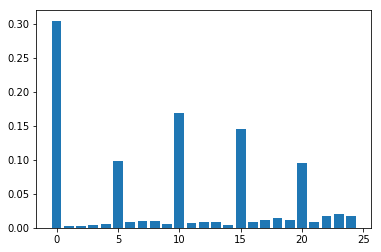

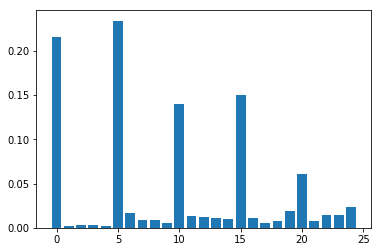

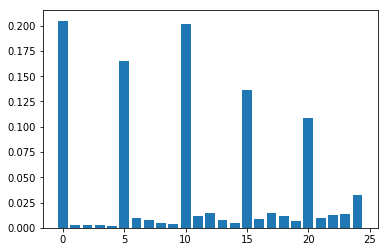

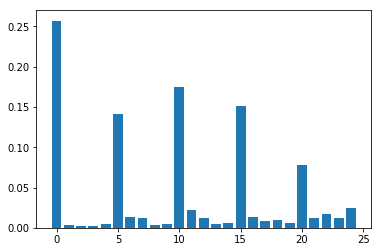

In [48]:
for i in range(num_mix_comp):
    _ = plt.bar(range(25), cl_mean[:,i])
    plt.show()

In [49]:
# the ones above are for all patients.
# Now consider when we stratify by severity -- select entries that have SOFA scores in certain ranges
# consider the argmax actions
df_orig = pd.read_csv('../data/MKdataset07Feb17.csv')
df_orig_val = df_orig.loc[df_orig['icustayid'].isin(val_df['icustayid'].unique())]
del df_orig

In [50]:
low_sofa = np.array(df_orig_val['SOFA'] <= 5)
med_sofa = np.array(df_orig_val['SOFA'] > 5)
med_sofa[(df_orig_val['SOFA']) > 15] = False
high_sofa = np.array(df_orig_val['SOi do love hii do love hiFA'] > 15)

In [51]:
# get the means for the third analysis for all three regimes
ml_mean_lowsofa = np.mean(marginal_lik[low_sofa], axis=0)
cl_mean_lowsofa= np.mean(cond_lik[low_sofa], axis=0)

ml_mean_medsofa = np.mean(marginal_lik[med_sofa], axis=0)
cl_mean_medsofa= np.mean(cond_lik[med_sofa], axis=0)

ml_mean_highsofa = np.mean(marginal_lik[high_sofa], axis=0)
cl_mean_highsofa= np.mean(cond_lik[high_sofa], axis=0)

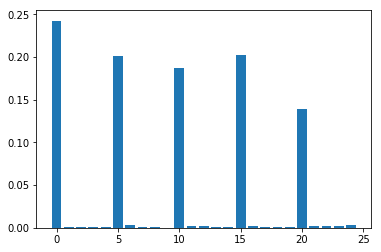

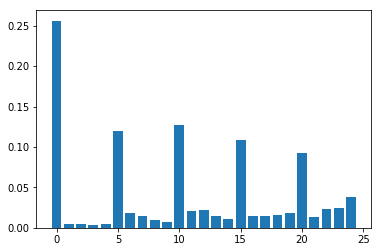

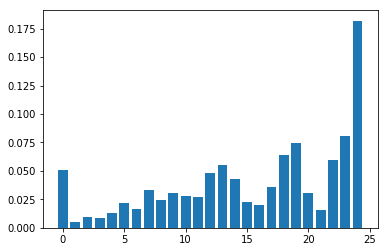

In [52]:
for m in [ml_mean_lowsofa, ml_mean_medsofa, ml_mean_highsofa]:
    _ = plt.bar(range(25), m)
    plt.show()

LOW SOFA


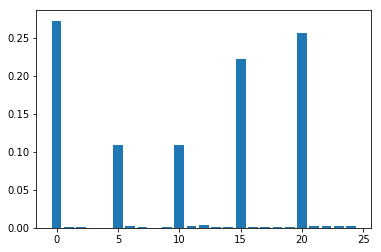

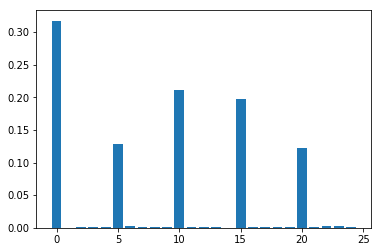

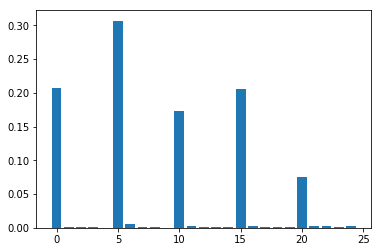

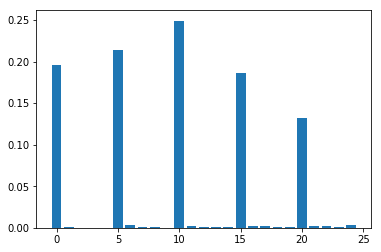

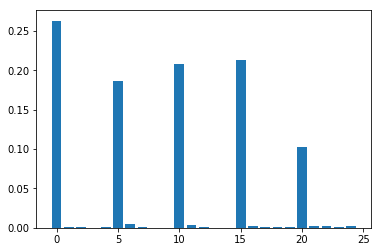

MED SOFA


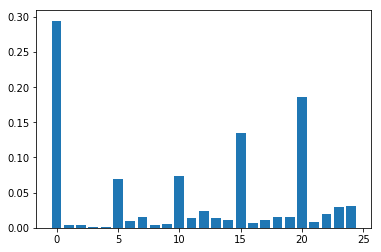

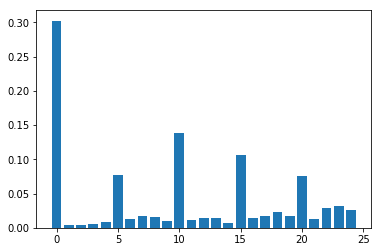

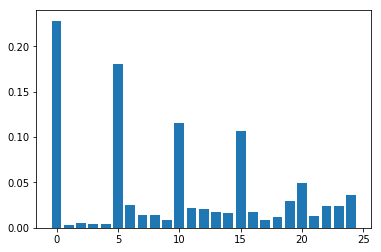

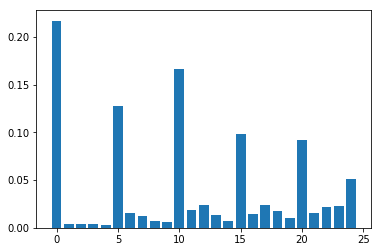

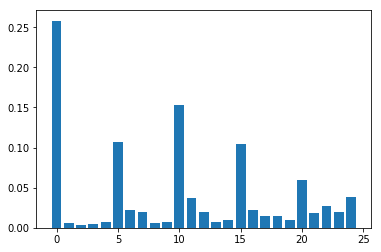

HIGH SOFA


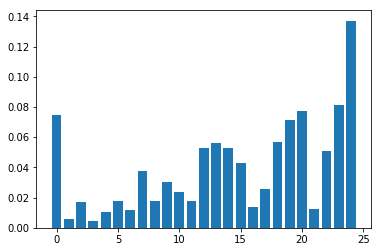

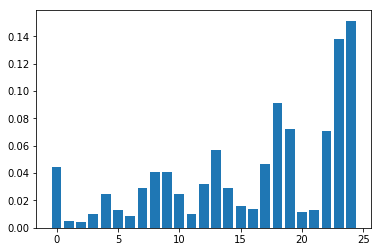

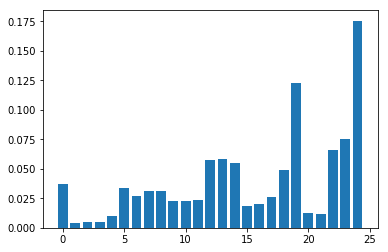

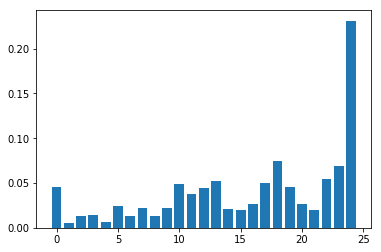

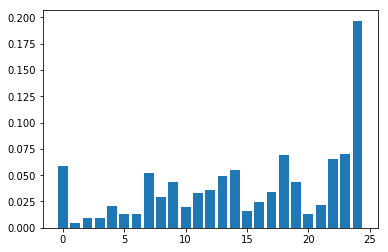

In [53]:
for ind, c in enumerate([cl_mean_lowsofa, cl_mean_medsofa, cl_mean_highsofa]):
    if ind == 0:
        print "LOW SOFA"
    elif ind == 1:
        print "MED SOFA"
    elif ind == 2:
        print "HIGH SOFA"
    for i in range(num_mixi do love hi_comp):
        _ = plt.bar(range(25), c[:,i])
        plt.show()